## 1) Config & Upload ZIP

In [1]:

#@title Upload your Kaggle ZIP (multi-CSV) or set a path
ZIP_PATH = "/content/archive.zip"  #@param {type:"string"}

# Colab upload (optional)
try:
    from google.colab import files  # type: ignore
    print("Colab detected. Use the chooser to upload your ZIP if needed.")
    up = files.upload()
    if up:
        # take first uploaded file as ZIP
        import io
        fname = list(up.keys())[0]
        with open(ZIP_PATH, "wb") as f:
            f.write(up[fname])
        print("Saved uploaded ZIP to:", ZIP_PATH)
except Exception as e:
    print("Colab upload helper not available, continuing with ZIP_PATH if present.")


Colab detected. Use the chooser to upload your ZIP if needed.


Saving archive.zip to archive.zip
Saved uploaded ZIP to: /content/archive.zip


## 2) Extract & Parse all CSVs

In [2]:

import zipfile, io, os, re, pandas as pd, numpy as np
from pathlib import Path

assert Path(ZIP_PATH).exists(), f"ZIP not found at {ZIP_PATH}. Upload or set path correctly."

def infer_symbol(file_name, df):
    # Try to infer symbol from filename (strip dirs + extension)
    base = os.path.basename(file_name)
    sym = re.sub(r"\.csv$", "", base, flags=re.IGNORECASE)
    sym = re.sub(r"[^A-Za-z0-9._-]", "", sym)[:20]
    # Fallback to a column if present
    for col in ["Symbol", "Ticker", "ticker", "symbol"]:
        if col in df.columns and pd.api.types.is_string_dtype(df[col]):
            val = str(df[col].dropna().iloc[0])[:20]
            if len(val) >= 1:
                sym = val
                break
    return sym

def coalesce_price_columns(df):
    # Return a single Series with prioritized price column
    candidates = [
        ["Adj Close", "AdjClose", "adj_close", "adjclose", "Adj_Close"],
        ["Close", "close"]
    ]
    for group in candidates:
        for c in group:
            if c in df.columns:
                s = pd.to_numeric(df[c], errors="coerce")
                if s.notna().sum() > 0:
                    return s, c
    # If nothing, try typical OHLC last resort:
    for c in ["Price", "Last", "End"]:
        if c in df.columns:
            s = pd.to_numeric(df[c], errors="coerce")
            if s.notna().sum() > 0:
                return s, c
    return None, None

def find_date_column(df):
    # Common date column names
    for c in ["Date", "date", "Timestamp", "timestamp"]:
        if c in df.columns:
            return c
    # no date column found
    return None

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    file_list = [f for f in zf.namelist() if f.lower().endswith(".csv")]
    print(f"Found {len(file_list)} CSVs.")
    frames = []
    meta_rows = []
    for f in file_list:
        try:
            df_i = pd.read_csv(zf.open(f))
        except Exception as e:
            print("Read error, skipping:", f, "->", e)
            continue

        date_col = find_date_column(df_i)
        if date_col is None:
            print("No date column, skipping:", f)
            continue
        # Parse dates
        df_i[date_col] = pd.to_datetime(df_i[date_col], errors="coerce", utc=False)
        df_i = df_i.dropna(subset=[date_col])
        df_i = df_i.sort_values(date_col)

        price_series, used_col = coalesce_price_columns(df_i)
        if price_series is None:
            print("No usable price column, skipping:", f)
            continue

        sym = infer_symbol(f, df_i)
        ser = pd.Series(price_series.values, index=df_i[date_col].values, name=sym)
        # Drop all-NA or nearly empty series
        na_ratio = ser.isna().mean()
        if na_ratio >= 0.9:
            print("Mostly NA, skipping:", sym, "from", f)
            continue

        frames.append(ser)
        meta_rows.append({
            "Ticker": sym,
            "SourceFile": f,
            "PriceColumn": used_col,
            "DataCompleteness": float(1.0 - na_ratio),
            "FirstDate": str(pd.to_datetime(ser.index.min()).date()) if len(ser)>0 else None,
            "LastDate": str(pd.to_datetime(ser.index.max()).date()) if len(ser)>0 else None,
            "RowCount": int(ser.notna().sum())
        })

# Merge to wide format (outer join on dates)
if not frames:
    raise RuntimeError("No usable CSVs with Date + Price found in the ZIP. Check column names and content.")

df_prices = pd.concat(frames, axis=1).sort_index()
df_meta = pd.DataFrame(meta_rows).drop_duplicates(subset=["Ticker"])

print("Merged shape:", df_prices.shape)
display(df_meta.head())
display(df_prices.head())


Found 12 CSVs.
Merged shape: (763, 12)


,Ticker,SourceFile,PriceColumn,DataCompleteness,FirstDate,LastDate,RowCount
0,AAPL,historical_data/AAPL.csv,Close,1.0,2019-05-31,2021-06-30,526
1,ADBE,historical_data/ADBE.csv,Close,1.0,2019-05-31,2021-06-30,526
2,AMZN,historical_data/AMZN.csv,Close,1.0,2019-05-31,2021-06-30,526
3,BTC-USD,historical_data/BTC-USD.csv,Close,1.0,2019-05-31,2021-07-01,759
4,FB,historical_data/FB.csv,Close,1.0,2019-05-31,2021-06-30,526


,AAPL,ADBE,AMZN,BTC-USD,FB,GCF,IRX,MSFT,NVDA,QCOM,TSLA,TXN
2019-05-31,42.897572,270.899994,1775.069946,8574.501953,177.470001,1305.800049,2.293,121.004944,33.731499,62.937698,37.032001,98.278275
2019-06-01,NaN,NaN,NaN,8564.016602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-02,NaN,NaN,NaN,8742.958008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-03,42.463867,259.029999,1692.689941,8208.995117,164.149994,1322.699951,2.280,117.247993,33.313152,62.786995,35.793999,99.088554
2019-06-04,44.017353,268.709991,1729.560059,7707.770996,167.500000,1323.400024,2.295,120.496185,35.609070,64.472992,38.720001,102.810135


## 3) Filter, Align & Clean

In [3]:

# Configurable thresholds
MAX_N_ASSETS = 30         #@param {type:"integer"}
MIN_DATA_COMPLETENESS = 0.85  #@param {type:"number"}
DROP_LEADING_TRAILING_NA = True  #@param {type:"boolean"}

# 3.1 filter by completeness
keep = df_meta[df_meta["DataCompleteness"] >= MIN_DATA_COMPLETENESS]["Ticker"].tolist()
df_prices = df_prices[keep] if keep else df_prices

# 3.2 drop assets with too many NaNs after alignment
na_frac = df_prices.isna().mean().sort_values()
ordered = na_frac.index.tolist()
df_prices = df_prices[ordered]

# 3.3 limit universe to top MAX_N_ASSETS by completeness
if len(df_prices.columns) > MAX_N_ASSETS:
    top_assets = na_frac.head(MAX_N_ASSETS).index.tolist()
    df_prices = df_prices[top_assets]
    df_meta = df_meta[df_meta["Ticker"].isin(top_assets)]

# 3.4 forward-fill/back-fill within each series
df_prices = df_prices.ffill().bfill()

# 3.5 optional: trim dates where all assets have data (common intersection)
if DROP_LEADING_TRAILING_NA:
    valid_mask = df_prices.notna().all(axis=1)
    if valid_mask.any():
        first_valid = valid_mask.idxmax()
        last_valid = valid_mask[::-1].idxmax()
        df_prices = df_prices.loc[first_valid:last_valid]

# Final sanity
print("Final prices shape:", df_prices.shape)
print("NA ratios (should be near 0):")
print(df_prices.isna().mean().sort_values(ascending=False).head())

# Reset index to have Date column first, then prices
out_prices = df_prices.reset_index().rename(columns={"index":"Date"})
out_prices.rename(columns={"level_0":"Date"}, inplace=True)  # in case of multiindex

# Update meta for final selection
df_meta = df_meta[df_meta["Ticker"].isin(out_prices.columns[1:])].copy()
df_meta = df_meta.sort_values("Ticker")
display(df_meta.head())
display(out_prices.head())


Final prices shape: (763, 12)
NA ratios (should be near 0):
BTC-USD    0.0
AAPL       0.0
ADBE       0.0
AMZN       0.0
FB         0.0
dtype: float64


,Ticker,SourceFile,PriceColumn,DataCompleteness,FirstDate,LastDate,RowCount
0,AAPL,historical_data/AAPL.csv,Close,1.0,2019-05-31,2021-06-30,526
1,ADBE,historical_data/ADBE.csv,Close,1.0,2019-05-31,2021-06-30,526
2,AMZN,historical_data/AMZN.csv,Close,1.0,2019-05-31,2021-06-30,526
3,BTC-USD,historical_data/BTC-USD.csv,Close,1.0,2019-05-31,2021-07-01,759
4,FB,historical_data/FB.csv,Close,1.0,2019-05-31,2021-06-30,526


,Date,BTC-USD,AAPL,ADBE,AMZN,FB,MSFT,QCOM,NVDA,TSLA,TXN,GCF,IRX
0,2019-05-31,8574.501953,42.897572,270.899994,1775.069946,177.470001,121.004944,62.937698,33.731499,37.032001,98.278275,1305.800049,2.293
1,2019-06-01,8564.016602,42.897572,270.899994,1775.069946,177.470001,121.004944,62.937698,33.731499,37.032001,98.278275,1305.800049,2.293
2,2019-06-02,8742.958008,42.897572,270.899994,1775.069946,177.470001,121.004944,62.937698,33.731499,37.032001,98.278275,1305.800049,2.293
3,2019-06-03,8208.995117,42.463867,259.029999,1692.689941,164.149994,117.247993,62.786995,33.313152,35.793999,99.088554,1322.699951,2.280
4,2019-06-04,7707.770996,44.017353,268.709991,1729.560059,167.500000,120.496185,64.472992,35.609070,38.720001,102.810135,1323.400024,2.295


## 4) Save Outputs

In [4]:

import os
os.makedirs("artifacts", exist_ok=True)
out_prices.to_csv("artifacts/merged_prices.csv", index=False)
df_meta.to_csv("artifacts/merged_metadata.csv", index=False)
print("Saved: artifacts/merged_prices.csv and artifacts/merged_metadata.csv")


Saved: artifacts/merged_prices.csv and artifacts/merged_metadata.csv


## 5) Quick Visual Check

<Figure size 1000x500 with 0 Axes>

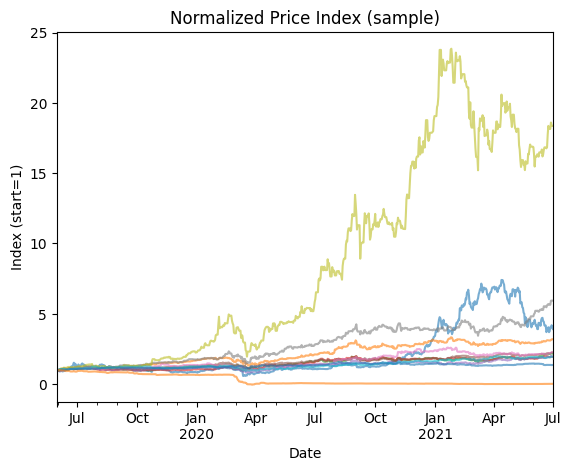

In [5]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
# normalize to 1.0
norm = out_prices.set_index('Date').pct_change().fillna(0)
norm = (1+norm).cumprod()
norm.plot(legend=False, alpha=0.6)
plt.title("Normalized Price Index (sample)")
plt.xlabel("Date"); plt.ylabel("Index (start=1)")
plt.show()


In [7]:
# === Load preprocessed Kaggle dataset ===
import pandas as pd

prices_path = '/content/artifacts/merged_prices.csv'      # uploaded file
meta_path = '/content/artifacts/merged_metadata.csv'      # optional (for sector/ESG caps)

df_prices = pd.read_csv(prices_path)
df_meta = pd.read_csv(meta_path)

print("Prices shape:", df_prices.shape)
print("Metadata sample:")
display(df_meta.head())

df_prices.head()

Prices shape: (763, 13)
Metadata sample:


,Ticker,SourceFile,PriceColumn,DataCompleteness,FirstDate,LastDate,RowCount
0,AAPL,historical_data/AAPL.csv,Close,1.0,2019-05-31,2021-06-30,526
1,ADBE,historical_data/ADBE.csv,Close,1.0,2019-05-31,2021-06-30,526
2,AMZN,historical_data/AMZN.csv,Close,1.0,2019-05-31,2021-06-30,526
3,BTC-USD,historical_data/BTC-USD.csv,Close,1.0,2019-05-31,2021-07-01,759
4,FB,historical_data/FB.csv,Close,1.0,2019-05-31,2021-06-30,526


,Date,BTC-USD,AAPL,ADBE,AMZN,FB,MSFT,QCOM,NVDA,TSLA,TXN,GCF,IRX
0,2019-05-31,8574.501953,42.897572,270.899994,1775.069946,177.470001,121.004944,62.937698,33.731499,37.032001,98.278275,1305.800049,2.293
1,2019-06-01,8564.016602,42.897572,270.899994,1775.069946,177.470001,121.004944,62.937698,33.731499,37.032001,98.278275,1305.800049,2.293
2,2019-06-02,8742.958008,42.897572,270.899994,1775.069946,177.470001,121.004944,62.937698,33.731499,37.032001,98.278275,1305.800049,2.293
3,2019-06-03,8208.995117,42.463867,259.029999,1692.689941,164.149994,117.247993,62.786995,33.313152,35.793999,99.088554,1322.699951,2.280
4,2019-06-04,7707.770996,44.017353,268.709991,1729.560059,167.500000,120.496185,64.472992,35.609070,38.720001,102.810135,1323.400024,2.295


In [9]:
# === Step 2 (robust): Clean & Compute Returns ===
import numpy as np
import pandas as pd

df = df_prices.copy()

# 1) Dates + sort
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date']).sort_values('Date').set_index('Date')

# 2) Force numeric, kill non-numeric columns early
df = df.apply(pd.to_numeric, errors='coerce')

# 3) Drop columns with too many NaNs (>10%)
keep = [c for c in df.columns if df[c].isna().mean() < 0.10]
df = df[keep]

# 4) Remove nonpositive prices (log undefined): set to NaN, then fill small gaps
df = df.where(df > 0)
df = df.ffill().bfill()

# 5) Drop columns that are still broken (any remaining NaNs or constant series)
df = df.loc[:, df.isna().sum() == 0]
df = df.loc[:, df.nunique() > 1]

# 6) Compute log returns safely (log(price).diff())
rets = np.log(df).diff().dropna()

# 7) Winsorize per-column (fixes your axis error)
#    Clip each column using its own 1%/99% quantiles
def _winsorize_col(s: pd.Series) -> pd.Series:
    q1, q99 = s.quantile(0.01), s.quantile(0.99)
    return s.clip(lower=q1, upper=q99)

rets = rets.apply(_winsorize_col, axis=0)

# 8) Final sanity: drop zero-variance assets (bad for optimization)
stds = rets.std()
rets = rets.loc[:, stds > 0]

tickers = rets.columns.tolist()
print(f"Assets loaded: {len(tickers)}")
print(f"Observations: {len(rets)} days")
display(rets.tail())


Assets loaded: 12
Observations: 762 days


,BTC-USD,AAPL,ADBE,AMZN,FB,MSFT,QCOM,NVDA,TSLA,TXN,GCF,IRX
Date,,,,,,,,,,,,
2021-06-27,0.073747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-06-28,-0.006233,0.012468,0.015645,0.012397,0.040952,0.013865,0.014926,0.048913,0.024770,0.017699,0.001687,-0.072321
2021-06-29,0.040785,0.011435,0.003306,0.001233,-0.010600,0.009924,0.020543,0.002087,-0.011625,0.007024,-0.009485,0.000000
2021-06-30,-0.023325,0.004611,-0.008688,-0.002317,-0.011950,-0.001844,0.002171,-0.001212,-0.001558,-0.003012,0.004528,0.000000
2021-07-01,-0.042818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002876,0.000000


MinVar:   ret=13.943%  vol=11.783%  Sharpe=1.01
GCF        0.748
AMZN       0.097
MSFT       0.073
TXN        0.058
FB         0.014
IRX        0.007
BTC-USD    0.004
TSLA       0.000
AAPL       0.000
ADBE       0.000
NVDA       0.000
QCOM       0.000
dtype: float64 

Tangency: ret=55.015%  vol=25.218%  Sharpe=2.10
GCF        0.339
NVDA       0.279
TSLA       0.276
BTC-USD    0.101
AAPL       0.005
IRX        0.000
QCOM       0.000
ADBE       0.000
AMZN       0.000
MSFT       0.000
FB         0.000
TXN        0.000
dtype: float64


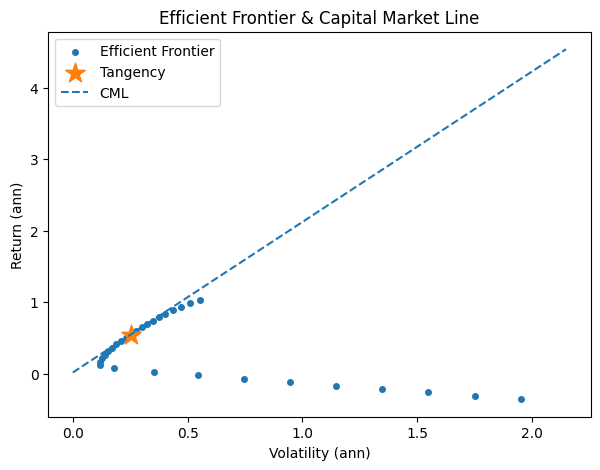

In [10]:
# === Step 4: Mean–Variance Optimization + Efficient Frontier ===
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Annualize mean & covariance
PER_YEAR = 252
mu = rets.mean().values * PER_YEAR
Sigma = rets.cov().values * PER_YEAR
tickers = rets.columns.tolist()

rf = 0.02  # set to your preferred risk-free (annualized)
bounds = (0.0, 1.0)  # long-only; relax if you want shorting

def stats(w, mu, Sigma, rf=0.0):
    w = np.asarray(w)
    ret = float(w @ mu)
    vol = math.sqrt(float(w @ Sigma @ w))
    sharpe = (ret - rf) / (vol + 1e-12)
    return ret, vol, sharpe

def _sector_caps_constraints(df_meta, caps: dict):
    cons = []
    if df_meta is None or not caps:
        return cons
    # expects df_meta with index=ticker and 'Sector' col
    for sector, cap in caps.items():
        idx = [i for i, t in enumerate(tickers) if t in df_meta.index
               and str(df_meta.loc[t, 'Sector']) == sector]
        if idx:
            cons.append({'type':'ineq', 'fun': lambda w, idx=idx, cap=cap: cap - np.sum(w[idx])})
    return cons

# OPTIONAL: sector caps
try:
    df_meta  # if you loaded metadata earlier
except NameError:
    df_meta = None
sector_caps = {}  # e.g., {'Tech': 0.5, 'Energy': 0.3}

def opt_min_var(mu, Sigma, bounds, sector_caps=None):
    n = len(mu)
    x0 = np.ones(n) / n
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    cons += _sector_caps_constraints(df_meta, sector_caps or {})
    res = minimize(lambda w: w @ Sigma @ w,
                   x0, method='SLSQP',
                   bounds=[bounds] * n, constraints=cons)
    return res.x

def opt_max_sharpe(mu, Sigma, rf, bounds, sector_caps=None):
    n = len(mu)
    x0 = np.ones(n) / n
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}]
    cons += _sector_caps_constraints(df_meta, sector_caps or {})
    def neg_sharpe(w):
        r, v, s = stats(w, mu, Sigma, rf)
        return -s
    res = minimize(neg_sharpe, x0, method='SLSQP',
                   bounds=[bounds] * n, constraints=cons)
    return res.x

def opt_target_return(mu, Sigma, r_target, bounds, sector_caps=None):
    n = len(mu)
    x0 = np.ones(n) / n
    cons = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},
        {'type': 'eq', 'fun': lambda w, r_target=r_target: w @ mu - r_target}
    ]
    cons += _sector_caps_constraints(df_meta, sector_caps or {})
    res = minimize(lambda w: w @ Sigma @ w,
                   x0, method='SLSQP',
                   bounds=[bounds] * n, constraints=cons)
    return res.x

# Compute key portfolios
w_minvar = opt_min_var(mu, Sigma, bounds, sector_caps=sector_caps)
w_tan    = opt_max_sharpe(mu, Sigma, rf, bounds, sector_caps=sector_caps)

r_min, v_min, s_min = stats(w_minvar, mu, Sigma, rf)
r_tan, v_tan, s_tan = stats(w_tan,    mu, Sigma, rf)

print(f"MinVar:   ret={r_min:.3%}  vol={v_min:.3%}  Sharpe={s_min:.2f}")
print(pd.Series(w_minvar, index=tickers).sort_values(ascending=False).round(3), '\n')
print(f"Tangency: ret={r_tan:.3%}  vol={v_tan:.3%}  Sharpe={s_tan:.2f}")
print(pd.Series(w_tan, index=tickers).sort_values(ascending=False).round(3))

# Efficient frontier
def efficient_frontier(mu, Sigma, bounds, npts=40, sector_caps=None):
    ret_targets = np.linspace(mu.min(), mu.max(), npts)
    vols, rets, weights = [], [], []
    for rt in ret_targets:
        w = opt_target_return(mu, Sigma, rt, bounds, sector_caps=sector_caps)
        r, v, _ = stats(w, mu, Sigma, rf)
        vols.append(v); rets.append(r); weights.append(w)
    return np.array(vols), np.array(rets), np.array(weights)

vols, rets_ann, Ws = efficient_frontier(mu, Sigma, bounds, npts=30, sector_caps=sector_caps)

# Plot frontier + Tangency + CML
plt.figure(figsize=(7,5))
plt.scatter(vols, rets_ann, s=16, label='Efficient Frontier')
plt.scatter([v_tan], [r_tan], marker='*', s=220, label='Tangency')
slope = (r_tan - rf) / (v_tan + 1e-12)
x = np.linspace(0, max(vols)*1.1, 50)
plt.plot(x, rf + slope*x, '--', label='CML')
plt.xlabel('Volatility (ann)')
plt.ylabel('Return (ann)')
plt.title('Efficient Frontier & Capital Market Line')
plt.legend()
plt.show()


In [11]:
# === Save artifacts ===
import os, json
os.makedirs('artifacts', exist_ok=True)

pd.Series(w_tan, index=tickers).to_csv('artifacts/weights_tangency.csv')
pd.Series(w_minvar, index=tickers).to_csv('artifacts/weights_minvar.csv')
rets.to_csv('artifacts/asset_returns.csv')

report = {
    "rf": rf,
    "tickers": tickers,
    "tangency": {"ret": r_tan, "vol": v_tan, "sharpe": s_tan},
    "minvar":   {"ret": r_min, "vol": v_min, "sharpe": s_min}
}
with open('artifacts/risk_report.json','w') as f:
    json.dump(report, f, indent=2)

print("Saved: artifacts/weights_tangency.csv, weights_minvar.csv, asset_returns.csv, risk_report.json")


Saved: artifacts/weights_tangency.csv, weights_minvar.csv, asset_returns.csv, risk_report.json



== MINVAR ==
VaR(95%) 1d:  -1.1601%   | CVaR(95%) 1d:  -1.4670%
VaR(95%) 21d: -4.3518%  | CVaR(95%) 21d: -5.6756%
Sim Drawdown median: -8.07% | min: -23.85%
Hist Sharpe: 1.01 | Hist Sortino: 1.21 | Hist MDD: -10.93%

== TANGENCY ==
VaR(95%) 1d:  -2.3755%   | CVaR(95%) 1d:  -3.0223%
VaR(95%) 21d: -7.2869%  | CVaR(95%) 21d: -9.9952%
Sim Drawdown median: -13.53% | min: -36.64%
Hist Sharpe: 2.10 | Hist Sortino: 2.70 | Hist MDD: -28.80%


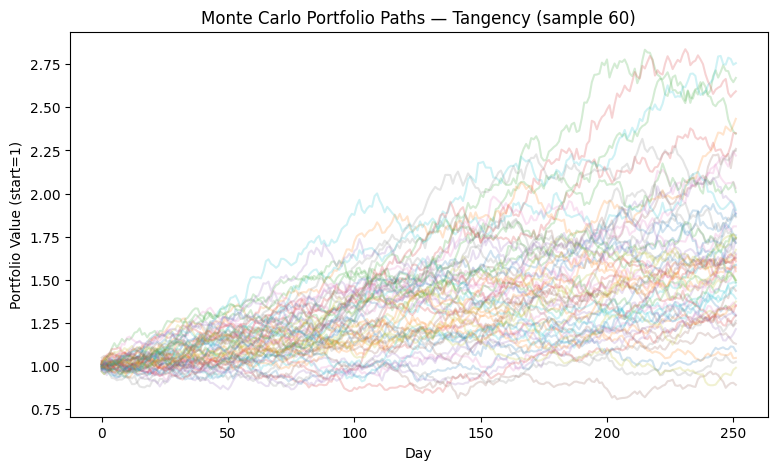

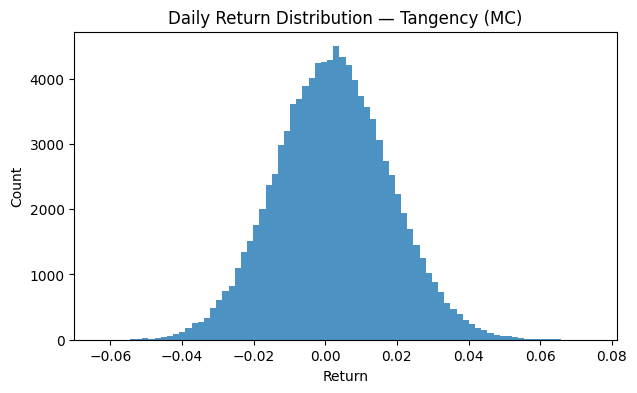


Saved artifacts/risk_report_mc.json


In [12]:
# === Step 6: Monte Carlo Risk (VaR/CVaR, Drawdowns) ===
import numpy as np, pandas as pd, json, os, math
import matplotlib.pyplot as plt

PER_YEAR = 252

def psd_fix(S):
    """Make covariance PSD via eigenvalue clip."""
    vals, vecs = np.linalg.eigh(S)
    vals = np.clip(vals, 1e-12, None)
    return (vecs * vals) @ vecs.T

def simulate_paths(mu_ann, Sigma_ann, w, n_days=252, n_paths=5000, s0=1.0, seed=42):
    """Simulate portfolio value paths from annualized mu/Sigma (log-return model)."""
    rng = np.random.default_rng(seed)
    # Daily parameters
    mu_d = mu_ann / PER_YEAR
    Sigma_d = Sigma_ann / PER_YEAR
    Sigma_d = psd_fix(Sigma_d)
    # Portfolio daily moments
    mu_p = float(w @ mu_d)
    var_p = float(w @ Sigma_d @ w)
    sigma_p = math.sqrt(max(var_p, 1e-18))

    # Simulate log-returns then convert to price path
    z = rng.standard_normal((n_paths, n_days))
    # Use geometric Brownian motion approximation on portfolio level
    r = mu_p - 0.5 * sigma_p**2 + sigma_p * z  # daily log-returns
    prices = np.exp(np.cumsum(r, axis=1)) * s0
    return prices, r  # prices shape: (paths, days), r shape: (paths, days)

def drawdown(path):
    peak = np.maximum.accumulate(path)
    dd = path / peak - 1.0
    return dd.min()

def var_cvar(returns, alpha=0.95):
    """1-day VaR/CVaR on arithmetic returns vector."""
    q = np.quantile(returns, 1 - alpha)
    tail = returns[returns <= q]
    cvar = tail.mean() if len(tail) else q
    return float(q), float(cvar)

# Choose portfolios to evaluate
ports = {
    "minvar": np.asarray(w_minvar),
    "tangency": np.asarray(w_tan),
}

risk = {}
for name, w in ports.items():
    prices, r_log = simulate_paths(mu, Sigma, w, n_days=252, n_paths=5000, s0=1.0, seed=123)
    # convert log-returns to arithmetic daily returns for VaR/metrics
    r = np.exp(r_log) - 1.0  # shape (paths, days)
    # 1-day VaR/CVaR (95%)
    var1, cvar1 = var_cvar(r.flatten(), alpha=0.95)
    # 21-day VaR/CVaR (approx via compounding simulated daily returns)
    r21 = (1 + r.reshape(-1, 21)).prod(axis=1) - 1.0
    var21, cvar21 = var_cvar(r21, alpha=0.95)

    # Drawdowns on sample of paths
    dd_samples = [drawdown(prices[i, :]) for i in range(200)]
    dd_med, dd_min = float(np.median(dd_samples)), float(np.min(dd_samples))

    # Historical ratios for reference (from your rets)
    hist_series = (rets @ w)
    sharpe_hist = float((hist_series.mean() * PER_YEAR - 0.02) / (hist_series.std() * np.sqrt(PER_YEAR) + 1e-12))
    downside = hist_series[hist_series < 0]
    sortino_hist = float((hist_series.mean() * PER_YEAR - 0.02) / (downside.std() * np.sqrt(PER_YEAR) + 1e-12))
    cum = (1 + hist_series).cumprod()
    mdd_hist = float((cum / cum.cummax() - 1).min())

    risk[name] = {
        "VaR_95_1d": var1,       # negative number ~ expected loss threshold
        "CVaR_95_1d": cvar1,
        "VaR_95_21d": var21,
        "CVaR_95_21d": cvar21,
        "DD_median_sim": dd_med, # negative
        "DD_min_sim": dd_min,    # worst of sampled
        "Sharpe_hist": sharpe_hist,
        "Sortino_hist": sortino_hist,
        "MDD_hist": mdd_hist,
    }

# Print summary
for k, v in risk.items():
    print(f"\n== {k.upper()} ==")
    print(f"VaR(95%) 1d:  {v['VaR_95_1d']:.4%}   | CVaR(95%) 1d:  {v['CVaR_95_1d']:.4%}")
    print(f"VaR(95%) 21d: {v['VaR_95_21d']:.4%}  | CVaR(95%) 21d: {v['CVaR_95_21d']:.4%}")
    print(f"Sim Drawdown median: {v['DD_median_sim']:.2%} | min: {v['DD_min_sim']:.2%}")
    print(f"Hist Sharpe: {v['Sharpe_hist']:.2f} | Hist Sortino: {v['Sortino_hist']:.2f} | Hist MDD: {v['MDD_hist']:.2%}")

# Plots: sample paths & loss distribution for tangency
prices_t, rlog_t = simulate_paths(mu, Sigma, ports["tangency"], n_days=252, n_paths=400, s0=1.0, seed=999)
plt.figure(figsize=(9,5))
for i in range(60):
    plt.plot(prices_t[i], alpha=0.2)
plt.title("Monte Carlo Portfolio Paths — Tangency (sample 60)")
plt.xlabel("Day"); plt.ylabel("Portfolio Value (start=1)")
plt.show()

r_t = np.exp(rlog_t) - 1.0
plt.figure(figsize=(7,4))
plt.hist(r_t.flatten(), bins=80, alpha=0.8)
plt.title("Daily Return Distribution — Tangency (MC)")
plt.xlabel("Return"); plt.ylabel("Count")
plt.show()

# Save risk report
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/risk_report_mc.json", "w") as f:
    json.dump(risk, f, indent=2)
print("\nSaved artifacts/risk_report_mc.json")


In [16]:
!pip -q install streamlit pyngrok scikit-learn pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.0 MB/s eta 0:00:00


In [17]:
NGROK_AUTH_TOKEN = "2zFKMMZWHPukNBKiGu5epxw6joh_3QarGiyDF5xv3V9DHm2dd"

In [18]:
%%writefile app.py
import os, io, json, math, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize

st.set_page_config(page_title="Portfolio Lab", layout="wide")

PER_YEAR = 252

# ---------- Helpers ----------
def parse_prices(file) -> pd.DataFrame:
    dfp = pd.read_csv(file)
    assert "Date" in dfp.columns, "merged_prices.csv must have a 'Date' column."
    dfp["Date"] = pd.to_datetime(dfp["Date"], errors="coerce")
    dfp = dfp.dropna(subset=["Date"]).sort_values("Date").set_index("Date")
    dfp = dfp.apply(pd.to_numeric, errors="coerce")
    dfp = dfp.where(dfp > 0)  # no nonpositive prices
    dfp = dfp.ffill().bfill()
    # drop dead or constant series
    dfp = dfp.loc[:, dfp.isna().sum() == 0]
    dfp = dfp.loc[:, dfp.nunique() > 1]
    return dfp

def compute_returns(dfp: pd.DataFrame) -> pd.DataFrame:
    rets = np.log(dfp).diff().dropna()
    # winsorize per column to reduce outliers
    def _winsor(s):
        q1, q99 = s.quantile(0.01), s.quantile(0.99)
        return s.clip(q1, q99)
    return rets.apply(_winsor, axis=0)

def annual_moments(rets: pd.DataFrame, shrink=False):
    mu = rets.mean().values * PER_YEAR
    if shrink:
        lw = LedoitWolf().fit(rets.values)  # daily covariance
        Sigma = lw.covariance_ * PER_YEAR
    else:
        Sigma = rets.cov().values * PER_YEAR
    return mu, Sigma, rets.columns.tolist()

def stats(w, mu, Sigma, rf):
    w = np.asarray(w)
    ret = float(w @ mu)
    vol = math.sqrt(max(1e-18, float(w @ Sigma @ w)))
    sharpe = (ret - rf) / (vol + 1e-18)
    return ret, vol, sharpe

def sector_constraints(df_meta, tickers, sector_caps):
    cons = []
    if df_meta is None or not sector_caps:
        return cons
    # normalize index
    dfm = df_meta.copy()
    if "Ticker" in dfm.columns:
        dfm = dfm.set_index("Ticker")
    if "Sector" not in dfm.columns:
        return cons
    for sec, cap in sector_caps.items():
        idx = [i for i, t in enumerate(tickers) if t in dfm.index and str(dfm.loc[t, "Sector"]) == sec]
        if idx:
            cons.append({"type": "ineq", "fun": lambda w, idx=idx, cap=cap: cap - np.sum(w[idx])})
    return cons

def optimize_portfolios(mu, Sigma, rf, bounds, tickers, sector_caps, df_meta):
    n = len(mu)
    x0 = np.ones(n) / n
    base_cons = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]
    base_cons += sector_constraints(df_meta, tickers, sector_caps)

    # min variance
    res_min = minimize(lambda w: w @ Sigma @ w, x0, method="SLSQP",
                       bounds=[bounds]*n, constraints=base_cons)
    w_min = res_min.x

    # max sharpe
    def neg_sharpe(w): return -stats(w, mu, Sigma, rf)[2]
    res_tan = minimize(neg_sharpe, x0, method="SLSQP",
                       bounds=[bounds]*n, constraints=base_cons)
    w_tan = res_tan.x
    return w_min, w_tan

def efficient_frontier(mu, Sigma, rf, bounds, tickers, sector_caps, df_meta, npts=40):
    r_targets = np.linspace(mu.min(), mu.max(), npts)
    vols, rets, W = [], [], []
    for rt in r_targets:
        n = len(mu)
        x0 = np.ones(n)/n
        cons = [{"type":"eq","fun": lambda w: np.sum(w)-1.0},
                {"type":"eq","fun": lambda w, rt=rt: w@mu - rt}]
        cons += sector_constraints(df_meta, tickers, sector_caps)
        res = minimize(lambda w: w @ Sigma @ w, x0, method="SLSQP",
                       bounds=[bounds]*n, constraints=cons)
        w = res.x
        r, v, _ = stats(w, mu, Sigma, rf)
        vols.append(v); rets.append(r); W.append(w)
    return np.array(vols), np.array(rets), np.array(W)

def psd_fix(S):
    vals, vecs = np.linalg.eigh(S)
    vals = np.clip(vals, 1e-12, None)
    return (vecs * vals) @ vecs.T

def mc_risk(mu, Sigma, w, n_days=252, n_paths=5000, rf=0.0, seed=42):
    rng = np.random.default_rng(seed)
    Sigma = psd_fix(Sigma)
    mu_d = mu / PER_YEAR
    var_d = float(w @ (Sigma / PER_YEAR) @ w)
    mu_p = float(w @ mu_d)
    sigma_p = math.sqrt(max(1e-18, var_d))
    z = rng.standard_normal((n_paths, n_days))
    r_log = mu_p - 0.5*sigma_p**2 + sigma_p*z
    prices = np.exp(np.cumsum(r_log, axis=1))
    r = np.exp(r_log) - 1.0
    def var_cvar(x, a=0.95):
        q = np.quantile(x, 1-a); tail = x[x<=q]
        return float(q), float(tail.mean() if len(tail) else q)
    var1, cvar1 = var_cvar(r.flatten(), 0.95)
    r21 = (1 + r.reshape(-1, 21)).prod(axis=1) - 1.0
    var21, cvar21 = var_cvar(r21, 0.95)
    # drawdown sample
    dds = []
    for i in range(min(200, n_paths)):
        p = prices[i]
        peak = np.maximum.accumulate(p)
        dd = (p/peak - 1).min()
        dds.append(dd)
    return {
        "VaR_95_1d": var1, "CVaR_95_1d": cvar1,
        "VaR_95_21d": var21, "CVaR_95_21d": cvar21,
        "DD_median_sim": float(np.median(dds)), "DD_min_sim": float(np.min(dds))
    }, prices, r

# ---------- UI ----------
st.sidebar.header("Upload data")
prices_file = st.sidebar.file_uploader("merged_prices.csv", type=["csv"])
meta_file   = st.sidebar.file_uploader("merged_metadata.csv (optional)", type=["csv"])

st.sidebar.header("Settings")
rf = st.sidebar.number_input("Risk-free rate (annual)", min_value=0.0, max_value=0.15, value=0.02, step=0.005)
use_shrink = st.sidebar.checkbox("Use Ledoit–Wolf covariance shrinkage", value=True)
allow_short = st.sidebar.checkbox("Allow limited shorting (–20% to 100%)", value=False)

st.sidebar.subheader("Sector Caps")
st.sidebar.caption("Requires 'Sector' in metadata. Example: Crypto≤0.15, Tech≤0.60")
caps_text = st.sidebar.text_input("Caps (JSON dict)", value="{}")
try:
    sector_caps = json.loads(caps_text) if caps_text.strip() else {}
except Exception:
    sector_caps = {}
    st.sidebar.error("Invalid JSON for sector caps.")

st.title("📈 Portfolio Lab — Efficient Frontier & Risk")

if prices_file is None:
    st.info("Upload your preprocessed **merged_prices.csv** to begin.")
    st.stop()

# Load data
df_prices = parse_prices(prices_file)
df_meta = None
if meta_file is not None:
    df_meta = pd.read_csv(meta_file)

# Returns & moments
rets = compute_returns(df_prices)
mu, Sigma, tickers = annual_moments(rets, shrink=use_shrink)
bounds = (-0.2, 1.0) if allow_short else (0.0, 1.0)

# Optimize
w_min, w_tan = optimize_portfolios(mu, Sigma, rf, bounds, tickers, sector_caps, df_meta)
r_min, v_min, s_min = stats(w_min, mu, Sigma, rf)
r_tan, v_tan, s_tan = stats(w_tan, mu, Sigma, rf)

# KPIs
k1, k2, k3, k4 = st.columns(4)
k1.metric("MinVar Return", f"{r_min:.2%}")
k2.metric("MinVar Vol", f"{v_min:.2%}")
k3.metric("Tan Sharpe", f"{s_tan:.2f}")
k4.metric("Universe", f"{len(tickers)} assets")

# Weights tables
c1, c2 = st.columns(2)
with c1:
    st.subheader("Min-Variance Weights")
    st.dataframe(pd.Series(w_min, index=tickers).sort_values(ascending=False).round(4))
with c2:
    st.subheader("Tangency Weights")
    st.dataframe(pd.Series(w_tan, index=tickers).sort_values(ascending=False).round(4))

# Frontier
vols, rets_ann, W = efficient_frontier(mu, Sigma, rf, bounds, tickers, sector_caps, df_meta, npts=30)
fig1, ax1 = plt.subplots()
ax1.scatter(vols, rets_ann, s=16)
ax1.scatter([v_tan],[r_tan], marker="*", s=220)
slope = (r_tan - rf) / (v_tan + 1e-18)
x = np.linspace(0, max(vols)*1.1, 50)
ax1.plot(x, rf + slope*x, "--")
ax1.set_xlabel("Volatility (annual)")
ax1.set_ylabel("Return (annual)")
ax1.set_title("Efficient Frontier & CML")
st.pyplot(fig1)

# MC Risk (optional)
st.markdown("---")
st.subheader("Monte Carlo Risk (VaR/CVaR, Drawdowns)")
npaths = st.number_input("Paths", min_value=1000, max_value=20000, value=5000, step=1000)
ndays  = st.number_input("Days",  min_value=126,  max_value=756,   value=252,  step=21)
if st.button("Run MC on Tangency"):
    risk, prices, r = mc_risk(mu, Sigma, w_tan, n_days=int(ndays), n_paths=int(npaths), rf=rf)
    st.write(risk)

    fig2, ax2 = plt.subplots()
    for i in range(min(50, prices.shape[0])):
        ax2.plot(prices[i], alpha=0.2)
    ax2.set_title("MC Paths — Tangency (sample)")
    ax2.set_xlabel("Day"); ax2.set_ylabel("Value (start=1)")
    st.pyplot(fig2)

    fig3, ax3 = plt.subplots()
    ax3.hist(r.flatten(), bins=80, alpha=0.85)
    ax3.set_title("Daily Return Distribution — Tangency (MC)")
    ax3.set_xlabel("Return"); ax3.set_ylabel("Count")
    st.pyplot(fig3)

# Download artifacts
st.markdown("---")
if st.button("Export weights & moments"):
    os.makedirs("artifacts", exist_ok=True)
    pd.Series(w_tan, index=tickers).to_csv("artifacts/weights_tangency.csv")
    pd.Series(w_min, index=tickers).to_csv("artifacts/weights_minvar.csv")
    rets.to_csv("artifacts/asset_returns.csv")
    report = {
        "rf": rf, "tickers": tickers,
        "tangency": {"ret": r_tan, "vol": v_tan, "sharpe": s_tan},
        "minvar": {"ret": r_min, "vol": v_min, "sharpe": s_min},
        "use_shrink": use_shrink, "allow_short": allow_short, "sector_caps": sector_caps
    }
    with open("artifacts/risk_report.json","w") as f:
        json.dump(report, f, indent=2)
    st.success("Saved artifacts in /artifacts")


Overwriting app.py


In [19]:
import os, time, threading
from pyngrok import ngrok

if NGROK_AUTH_TOKEN:
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Close old tunnels
for t in ngrok.get_tunnels():
    ngrok.disconnect(t.public_url)

public_url = ngrok.connect(8501, "http")
print("Public URL:", public_url)

def run():
    os.system("streamlit run app.py --server.port 8501 --server.address 0.0.0.0")
threading.Thread(target=run, daemon=True).start()

time.sleep(3)
print("If it hasn't loaded yet, give it a few seconds and refresh the URL above.")


Public URL: NgrokTunnel: "https://d1e4b18e3eda.ngrok-free.app" -> "http://localhost:8501"
If it hasn't loaded yet, give it a few seconds and refresh the URL above.
